# **CIS 6200 Spring 2024 Homework 3**


Objective:
*   Perform object detection using a multimodal architecture
*   Learn about comparison metrics of similarity in latent space

Tasks:

1. Import a multimodal network that can be used to do object detection.

2. Which metric are you using for similarity between the text prompt and the image?

3. Is the method you are using different from YOLO? Elaborate your answer. If yes, what would be the advantages and disadvantages over YOLO.

Optional but fun!
4. Can you think of a method to adapt the architecture to give an end to end framework? i.e. given the image and prompt, the output is a cropped image or the original image with a bounding box drawn.



**Note: Answers to the questions need to be submitted in the corresponding PDF submission along with this coding submission on gradescope.**

## Required Imports
Feel free to add other libraries you want to use for this homework

In [11]:
!pip3 install -q datasets
from datasets import load_dataset
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import gdown
from PIL import Image
import numpy as np

## Importing the image

In [12]:
url = 'https://drive.google.com/file/d/1xjP1g2SpDOuZt8n0G8zDco-lCIrdguQ7/view?usp=share_link'
gdown.download(url=url, output='input_img.png', quiet=False, fuzzy=True)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1xjP1g2SpDOuZt8n0G8zDco-lCIrdguQ7

but Gdown can't. Please check connections and permissions.

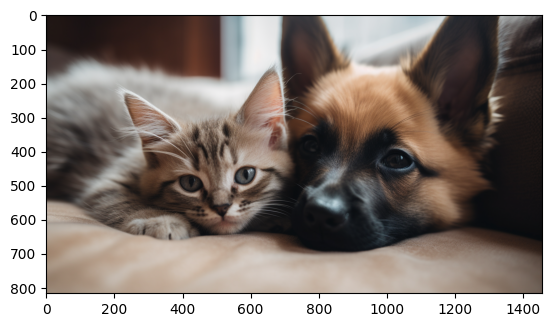

In [13]:
img=np.array(Image.open('/content/input_img.png').convert('RGB'))
plt.imshow(img)
transform = transforms.ToTensor()
img_tensor = transform(img)

In [14]:
img_tensor.shape

torch.Size([3, 816, 1456])

You need to pick a multimodal model from the Hugging Face library that can be used to perform object detection. Essentially, given a text prompt, you want to return a cropped portion of the image corresponding to the promt. You have a couple of choices:

1. Type of multimodal architecture (you might want to look into models that can perform zero-shot image classification).
2. How to break the images into patches to feed into your network.
3. How to process the image to get the correct patch.

In [15]:
from transformers import CLIPProcessor, CLIPModel
import torch
from torchvision.transforms.functional import to_pil_image

model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')








In [16]:
# Function to split the tensor image into patches
def get_tensor_patches(img_tensor, patch_size=224, overlap=0):
    C, H, W = img_tensor.shape
    patches = []

    step_size = patch_size - overlap
    for i in range(0, H-patch_size+1, step_size):
        for j in range(0, W-patch_size+1, step_size):
            patch = img_tensor[:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)

    return patches

Processing prompt: Picture of a cat


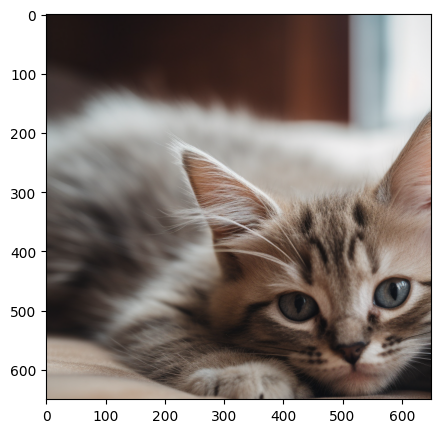

Processing prompt: Dog lying on the floor


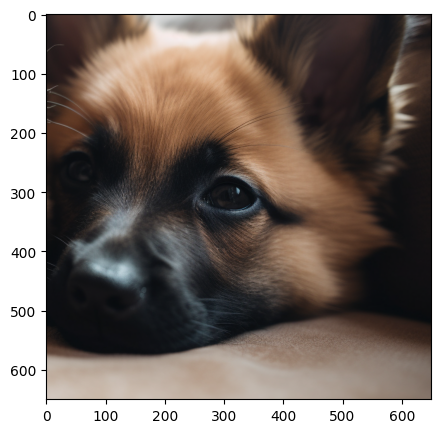

In [23]:
patches = get_tensor_patches(img_tensor, patch_size=650, overlap=530)


text_prompts = ["Picture of a cat", "Dog lying on the floor"]

for prompt in text_prompts:
    print(f"Processing prompt: {prompt}")
    inputs = processor(text=[prompt], return_tensors="pt", padding=True)
    prompt_embeddings = model.get_text_features(**inputs)

    highest_similarity = -float('Inf')
    best_patch = None
    for patch in patches:
        patch = to_pil_image(patch)
        patch_processed = processor(images=patch, return_tensors="pt", padding=True).pixel_values
        patch_embeddings = model.get_image_features(patch_processed)

        similarity = torch.nn.functional.cosine_similarity(prompt_embeddings, patch_embeddings, dim=1)


        if similarity > highest_similarity:
            highest_similarity = similarity
            best_patch = patch


    # Displaying the best patch
    plt.figure(figsize=(5,5))
    plt.imshow(best_patch)
    plt.show()

Uncomment the code block below to view all the patches

In [22]:
# print(len(patches))

# for best_patch in patches:
#     plt.figure(figsize=(5,5))
#     plt.imshow(to_pil_image(best_patch))
#     plt.show()


You should run your model for the following two promts


1.   Picture of a cat
2.   Dog lying on the floor

The expected outputs for the following promts would be similar to the images given below

Picture of a cat

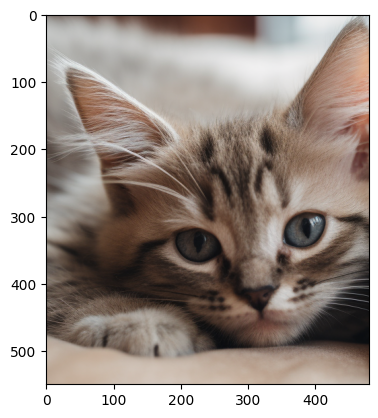

In [19]:
plt.imshow(img[150:700,200:680,:])

Dog lying on the floor

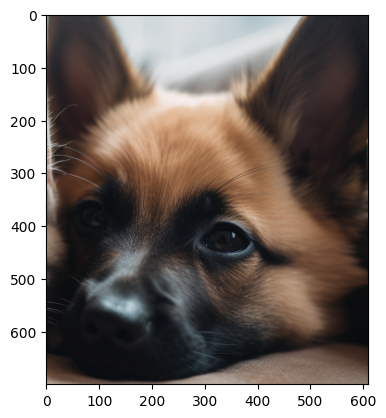

In [20]:
plt.imshow(img[:700,690:1300,:])